<h1>Prepare Environment</h1>

In [1]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import time

<h1>Loading dataset</h1>

In [4]:
DATA_DIR = './CamVid/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# Lets look at data we have
"""
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
"""
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'])

image, mask = dataset[5] # get some sample

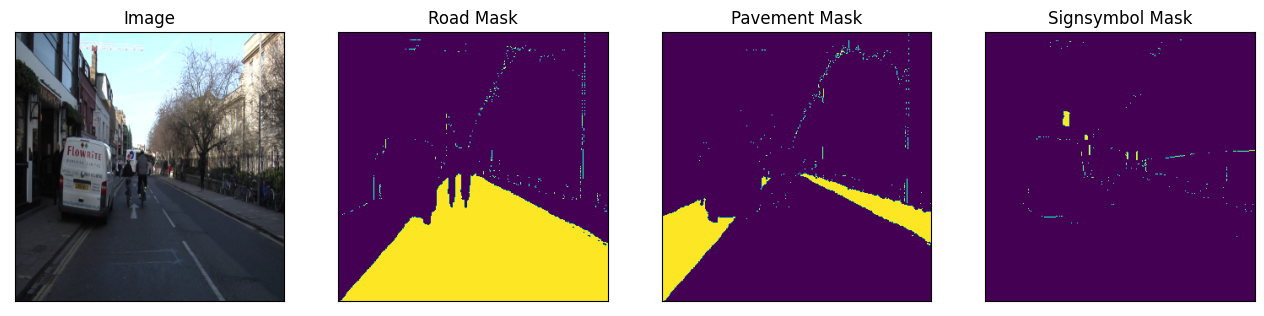

In [7]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

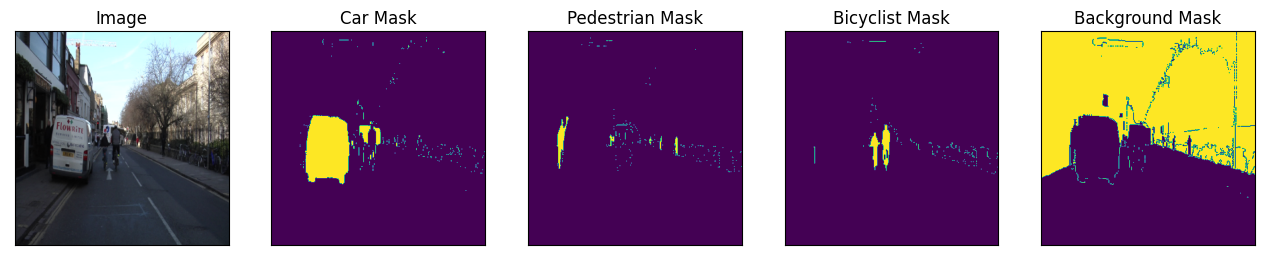

In [8]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Augmentation</h1>

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'], 
                  augmentation=get_training_augmentation())

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
image, mask = dataset[20] # get some sample

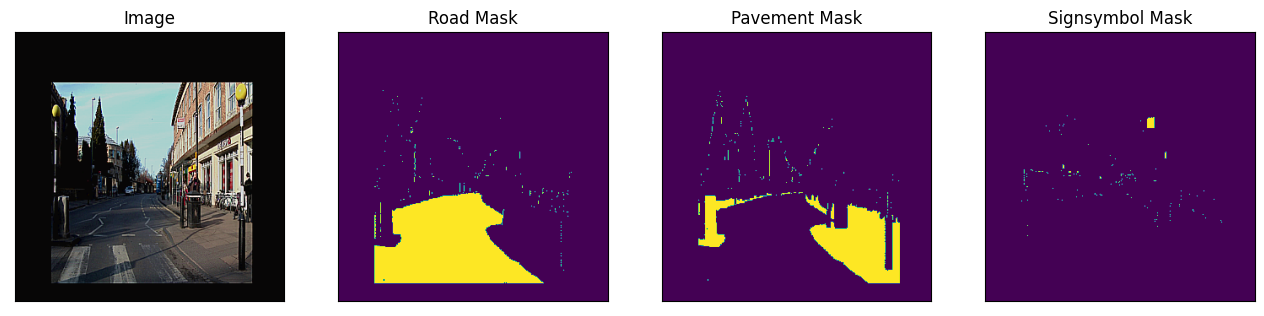

In [11]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

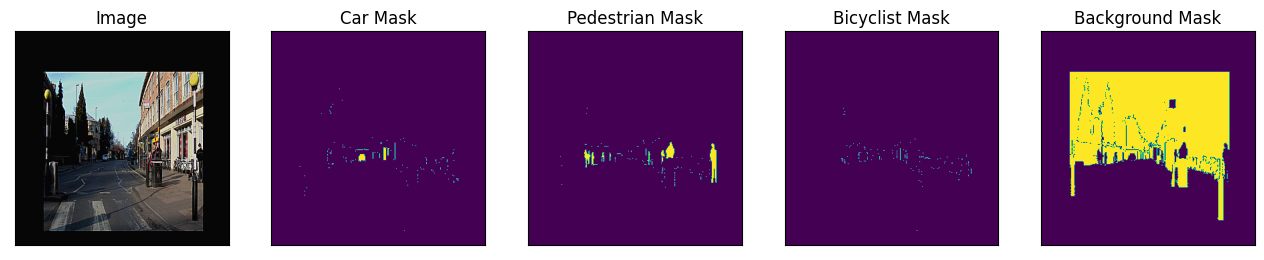

In [12]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Segmentation Model Training</h1>

In [13]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [14]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['road', 'pavement', 'signsymbol','car', 'pedestrian', 'bicyclist']
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2021-11-28 01:35:48.138236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 01:35:48.143614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 01:35:48.143985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 01:35:48.144866: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

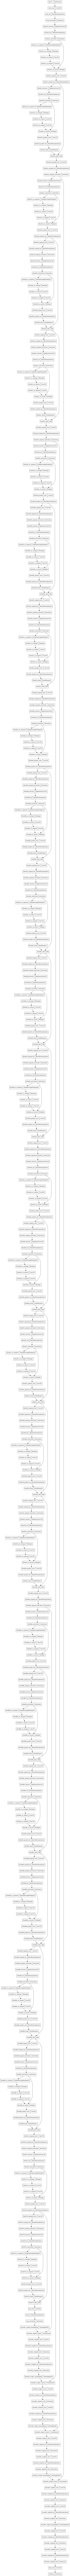

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/efficientnetb3_Unet.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [21]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/tmp/ipykernel_55583/1794659408.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250


2021-11-28 01:36:04.736814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-11-28 01:36:06.327522: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-28 01:36:06.857873: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-28 01:36:06.934583: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

91/91 [==============================] - ETA: 0s - loss: 0.8071 - iou_score: 0.1807 - f1-score: 0.2324

2021-11-28 01:36:42.331525: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


91/91 [==============================] - 54s 428ms/step - loss: 0.8071 - iou_score: 0.1807 - f1-score: 0.2324 - val_loss: 0.7387 - val_iou_score: 0.2604 - val_f1-score: 0.2946 - lr: 1.0000e-04
Epoch 2/250
91/91 [==============================] - 37s 403ms/step - loss: 0.6738 - iou_score: 0.3648 - f1-score: 0.4281 - val_loss: 0.6376 - val_iou_score: 0.3686 - val_f1-score: 0.4204 - lr: 1.0000e-04
Epoch 3/250
91/91 [==============================] - 37s 404ms/step - loss: 0.6160 - iou_score: 0.4078 - f1-score: 0.4684 - val_loss: 0.5973 - val_iou_score: 0.3883 - val_f1-score: 0.4393 - lr: 1.0000e-04
Epoch 4/250
91/91 [==============================] - 37s 405ms/step - loss: 0.5770 - iou_score: 0.4365 - f1-score: 0.5064 - val_loss: 0.5905 - val_iou_score: 0.3842 - val_f1-score: 0.4430 - lr: 1.0000e-04
Epoch 5/250
91/91 [==============================] - 37s 406ms/step - loss: 0.5468 - iou_score: 0.4554 - f1-score: 0.5289 - val_loss: 0.5616 - val_iou_score: 0.4113 - val_f1-score: 0.4763 - lr

Epoch 40/250
91/91 [==============================] - 37s 411ms/step - loss: 0.3583 - iou_score: 0.5968 - f1-score: 0.6859 - val_loss: 0.3509 - val_iou_score: 0.6095 - val_f1-score: 0.7203 - lr: 5.0000e-05
Epoch 41/250
91/91 [==============================] - 36s 399ms/step - loss: 0.3618 - iou_score: 0.5961 - f1-score: 0.6852 - val_loss: 0.3596 - val_iou_score: 0.6024 - val_f1-score: 0.7128 - lr: 5.0000e-05
Epoch 42/250
91/91 [==============================] - 36s 399ms/step - loss: 0.3627 - iou_score: 0.5956 - f1-score: 0.6822 - val_loss: 0.3683 - val_iou_score: 0.5945 - val_f1-score: 0.7046 - lr: 5.0000e-05
Epoch 43/250
91/91 [==============================] - 36s 399ms/step - loss: 0.3594 - iou_score: 0.5969 - f1-score: 0.6855 - val_loss: 0.3654 - val_iou_score: 0.5908 - val_f1-score: 0.7016 - lr: 5.0000e-05
Epoch 44/250
91/91 [==============================] - 36s 399ms/step - loss: 0.3543 - iou_score: 0.6012 - f1-score: 0.6892 - val_loss: 0.3597 - val_iou_score: 0.6012 - val_f1-s

91/91 [==============================] - 36s 399ms/step - loss: 0.3505 - iou_score: 0.6077 - f1-score: 0.6966 - val_loss: 0.3433 - val_iou_score: 0.6168 - val_f1-score: 0.7263 - lr: 6.2500e-06
Epoch 78/250
91/91 [==============================] - ETA: 0s - loss: 0.3468 - iou_score: 0.6090 - f1-score: 0.6974
Epoch 00078: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
91/91 [==============================] - 36s 399ms/step - loss: 0.3468 - iou_score: 0.6090 - f1-score: 0.6974 - val_loss: 0.3452 - val_iou_score: 0.6151 - val_f1-score: 0.7244 - lr: 6.2500e-06
Epoch 79/250
91/91 [==============================] - 36s 399ms/step - loss: 0.3479 - iou_score: 0.6086 - f1-score: 0.6976 - val_loss: 0.3449 - val_iou_score: 0.6147 - val_f1-score: 0.7243 - lr: 3.1250e-06
Epoch 80/250
91/91 [==============================] - 36s 399ms/step - loss: 0.3477 - iou_score: 0.6101 - f1-score: 0.6979 - val_loss: 0.3450 - val_iou_score: 0.6149 - val_f1-score: 0.7247 - lr: 3.1250e-06
Epoch 8

<h1>Model Evaluation</h1>

In [22]:
print('Time training:{} (s)'.format(time_training))

Time training:3795.621105670929 (s)


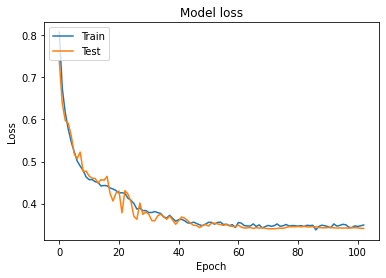

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

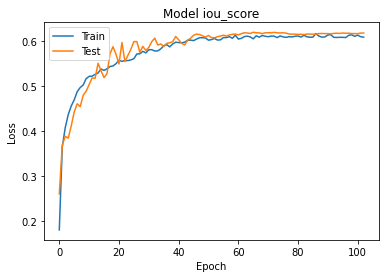

In [24]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [26]:
# load best weights
model.load_weights('./checkpoint/efficientnetb3_Unet.h5')

In [27]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/tmp/ipykernel_55583/2477453485.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores  = model.evaluate_generator(test_dataloader)


Loss:0.42977
mean iou_score:0.5372
mean f1-score:0.61505


In [28]:
df = pd.DataFrame({'backbone':[BACKBONE],'model':['Unet'],'Time_training':[time_training],
                   'loss':[scores[0]],'Iou_score':[scores[1]]})

In [29]:
df

backbone model  Time_training      loss  Iou_score
0  efficientnetb3  Unet    3795.621106  0.429767   0.537205

In [30]:
data = pd.read_excel('Evaluation_model.xlsx')
data = data[['backbone','model','Time_training','loss','Iou_score']]
data

backbone model  Time_training      loss  Iou_score
0  efficientnetb3   FPN    5052.327916  0.428663   0.537585
1     inceptionv3  Unet    8913.769664  0.443069   0.527323

In [31]:
df = pd.concat([df,data],axis=0)
df

backbone model  Time_training      loss  Iou_score
0  efficientnetb3  Unet    3795.621106  0.429767   0.537205
0  efficientnetb3   FPN    5052.327916  0.428663   0.537585
1     inceptionv3  Unet    8913.769664  0.443069   0.527323

In [32]:
df.to_excel('Evaluation_model.xlsx')

<h1>Evaluation on Test</h1>

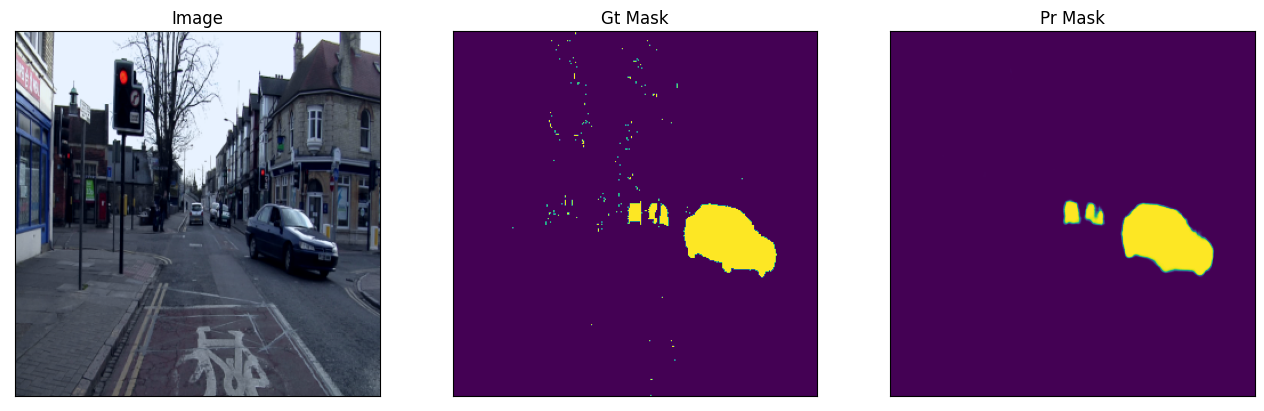

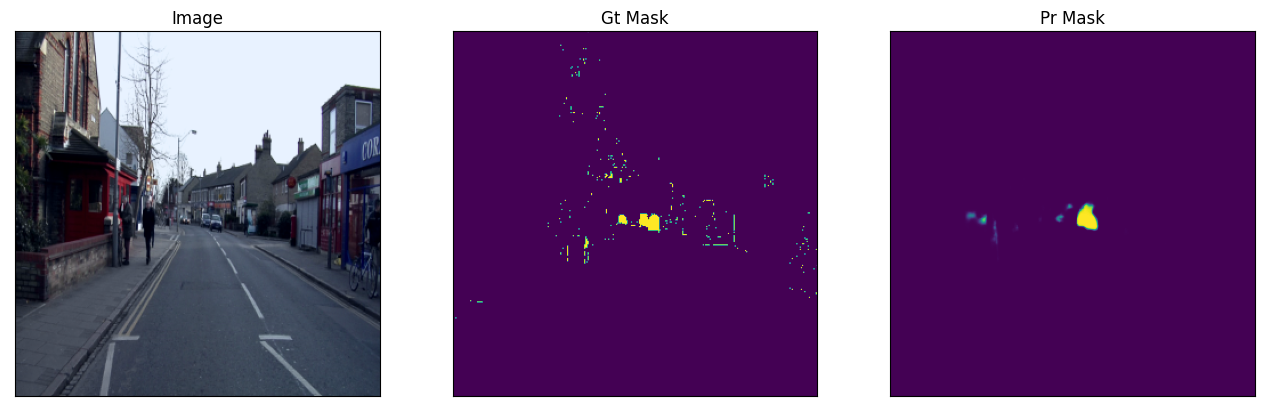

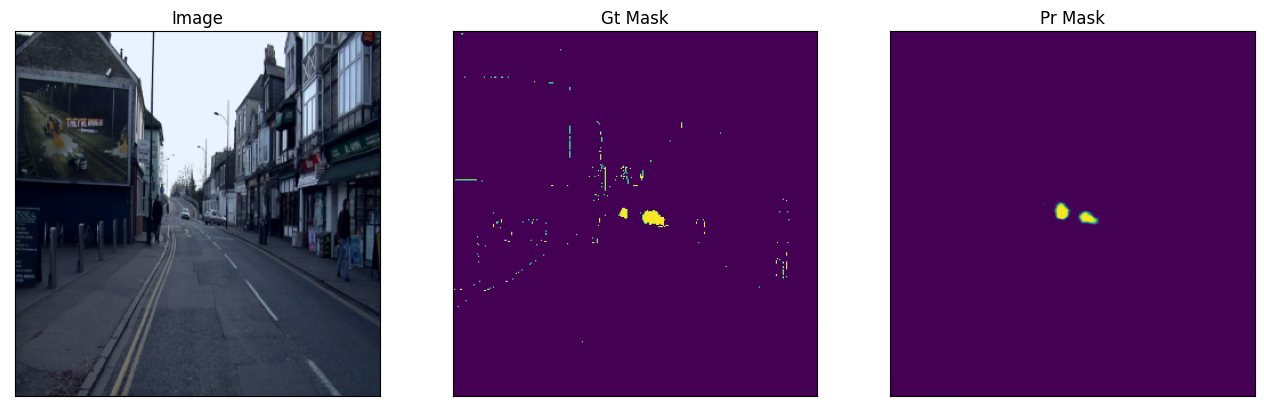

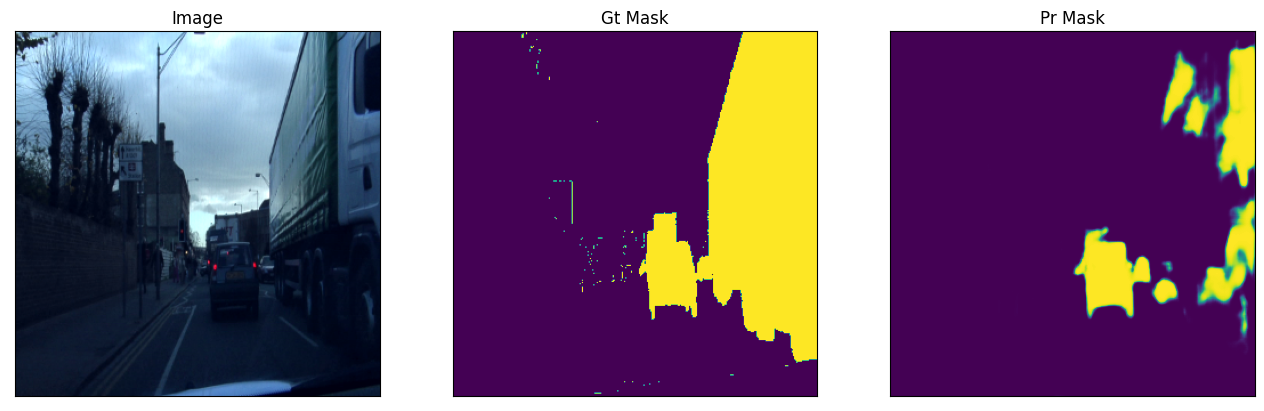

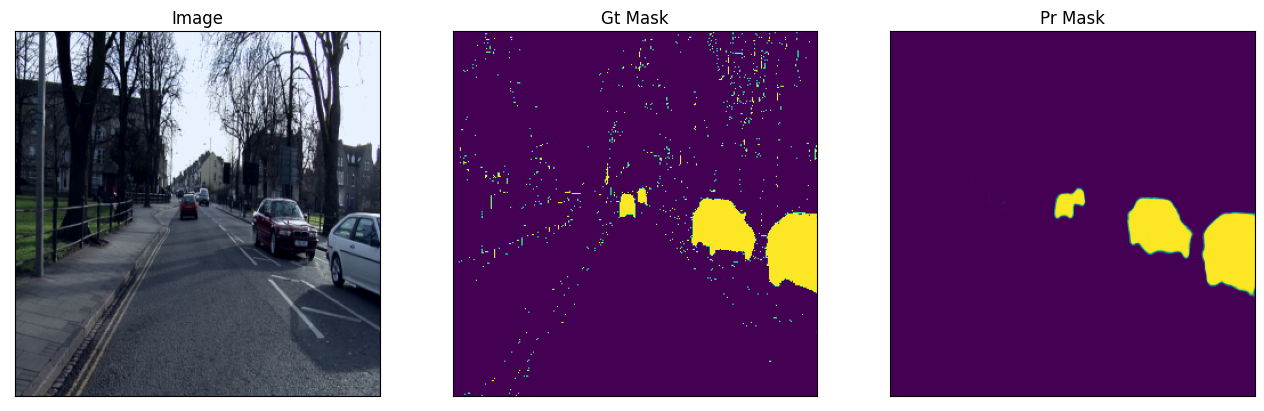

In [33]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,3].squeeze(),
        pr_mask=pr_mask[...,3].squeeze(),
    )